# Step1: Load the Data
- First, unpickle all the train and test files
- Then convert the image format to (width x height x num_channel)

In [ ]:
# Load the packages needed
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Put file path as a string here
CIFAR_DIR = "/content/drive/MyDrive/cifar-10-batches-py/"

#The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. 
#Each of these files is a Python "pickled" object produced with cPickle.

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [ ]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
all_data = [0,1,2,3,4,5,6]

for i, dir in zip(all_data, dirs):
    all_data[i] = unpickle(CIFAR_DIR + dir)

batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [ ]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [ ]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:

- data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

- label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [ ]:
# Display a single image using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

X = data_batch1[b"data"]
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
X[0].max()

255

In [ ]:
(X[0]/255).max()

1.0

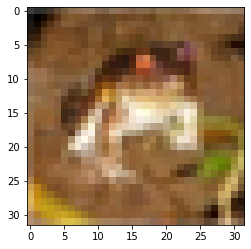

In [ ]:
plt.imshow(X[0])

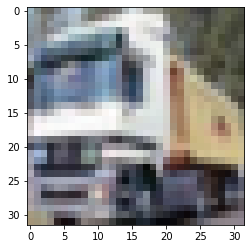

In [ ]:
plt.imshow(X[1])

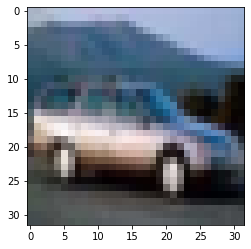

In [ ]:
plt.imshow(X[4])

# Step2: Data Processing

Train and test split

In [ ]:
train_x = np.concatenate((data_batch1[b'data'], data_batch2[b'data'], data_batch3[b'data'], data_batch4[b'data'], data_batch5[b'data']),axis=0)
train_y = np.concatenate((data_batch1[b'labels'], data_batch2[b'labels'], data_batch3[b'labels'], data_batch4[b'labels'], data_batch5[b'labels']),axis=0)
test_x = test_batch[b'data']
test_y = test_batch[b'labels']

# convert the image format to (width x height x num_channel)
train_x = np.transpose(np.reshape(train_x, (50000,3,32,32)), (0,2,3,1))
test_x = np.transpose(np.reshape(test_x, (10000,3,32,32)), (0,2,3,1))
 
# Normalize the data between 0 and 1
x_train = train_x.astype('float32')
x_test = test_x.astype('float32')
y_train = np.expand_dims(train_y,axis=-1)
y_test = np.expand_dims(test_y,axis=-1)


In [ ]:
#z-score normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# Step3: Model

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

#training
batch_size = 64
 
opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/125
781/781 [==============================] - 32s 31ms/step - loss: 2.3500 - accuracy: 0.3476 - val_loss: 1.5788 - val_accuracy: 0.5228
Epoch 2/125
781/781 [==============================] - 24s 31ms/step - loss: 1.3262 - accuracy: 0.5629 - val_loss: 1.1477 - val_accuracy: 0.6590
Epoch 3/125
781/781 [==============================] - 24s 30ms/step - loss: 1.0952 - accuracy: 0.6442 - val_loss: 1.0237 - val_accuracy: 0.7001
Epoch 4/125
781/781 [==============================] - 24s 31ms/step - loss: 0.9921 - accuracy: 0.6873 - val_loss: 0.9191 - val_accuracy: 0.7200
Epoch 5/125
781/781 [==============================] - 24s 30ms/step - loss: 0.9232 - accuracy: 0.7115 - val_loss: 0.8701 - val_accuracy: 0.7476
Epoch 6/125
781/781 [==============================] - 24s 30ms/step - loss: 0.8668 - accuracy: 0.7310 - val_loss: 0.7726 - val_accuracy: 0.7695
Epoch 7/125
781/781 [==============================] - 24s 30ms/step - loss: 0.8299 - accuracy: 0.7465 - val_loss: 0.8465 - val_ac

In [ ]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print(f'\nTest accuracy: {scores[1]*100:.2f}%, loss: {scores[0]:.2f}')

79/79 [==============================] - 0s 5ms/step - loss: 0.4358 - accuracy: 0.8936

Test accuracy: 89.36%, loss: 0.44
